In [224]:
# Import dependencies 
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from prophet import Prophet
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split


In [225]:
# Load the news_articles.csv into a DataFrame.
stock_data_df = pd.read_csv('Resources/stock_yfinance_data.csv')
tweet_data_df = pd.read_csv('Resources/stock_tweets.csv')


# Prepare Stock Data

In [226]:
# Display the stock data 
stock_names_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']

# Filter DataFrame to only include specified stocks
filtered_stock_data_df = stock_data_df[stock_data_df['Stock Name'].isin(stock_names_of_interest)]

# Remove unnecessary columns
filtered_stock_data_df =filtered_stock_data_df.drop(columns=['High', 'Low', 'Adj Close', 'Volume'])

# Add a new column to calculate the price change
filtered_stock_data_df['Price Change'] =filtered_stock_data_df['Close'] - filtered_stock_data_df['Open']

# Remove the Open and Close columns
filtered_stock_data_df = filtered_stock_data_df[['Date', 'Stock Name', 'Price Change']]

filtered_stock_data_df


,Date,Stock Name,Price Change
0,2021-09-30,TSLA,-1.839996
1,2021-10-01,TSLA,-1.059998
2,2021-10-04,TSLA,-4.989990
3,2021-10-05,TSLA,-1.403351
4,2021-10-06,TSLA,2.183319
...,...,...,...
1255,2022-09-23,AMZN,-2.220001
1256,2022-09-26,AMZN,1.849998
1257,2022-09-27,AMZN,-2.789993
1258,2022-09-28,AMZN,3.630005


# Prepare Tweet Data

In [227]:
tweet_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80793 entries, 0 to 80792
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          80793 non-null  object
 1   Tweet         80793 non-null  object
 2   Stock Name    80793 non-null  object
 3   Company Name  80793 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


In [228]:
# Display the tweet data
tweet_data_df.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [229]:
# Convert the 'Date' column to a datetime object
tweet_data_df['Date'] = pd.to_datetime(tweet_data_df['Date'])
tweet_data_df['Date'] = tweet_data_df['Date'].dt.date

# Filter the DataFrame to only include the specified stocks
tweets_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']
filtered_tweet_data_df = tweet_data_df[tweet_data_df['Stock Name'].isin(tweets_of_interest)]
filtered_tweet_data_df = filtered_tweet_data_df[['Date', 'Stock Name', 'Tweet']]

filtered_tweet_data_df

,Date,Stock Name,Tweet
0,2022-09-29,TSLA,Mainstream media has done an amazing job at br...
1,2022-09-29,TSLA,Tesla delivery estimates are at around 364k fr...
2,2022-09-29,TSLA,3/ Even if I include 63.0M unvested RSUs as of...
3,2022-09-29,TSLA,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...
4,2022-09-29,TSLA,"@RealDanODowd @Tesla Stop trying to kill kids,..."
...,...,...,...
52435,2021-09-30,AMZN,My top 10 holdings make up 66% of my portfolio...
52436,2021-09-30,AMZN,Amazon $AMZN has 4X the market cap of Alibaba ...
52437,2021-09-30,AMZN,Returns over the last 10 Years:\n\nBitcoin $BT...
52438,2021-09-30,AMZN,Great snapshot of what it looks like when an i...


### Implement VADER Sentiment Analyzer on the Tweet data

In [230]:
# Initialize the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentences = filtered_tweet_data_df["Tweet"]

# Function to analyze sentiment of each sentence
def analyze_sentiment(sentences):
    return analyzer.polarity_scores(sentences)

def vader_sentiment_label(vader_score):
    if vader_score >= 0.05:
        return 'Positive'
    elif vader_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment analysis to each tweet and create new columns
filtered_tweet_data_df[['Neg', 'Neu', 'Pos', 'Compound']] = filtered_tweet_data_df['Tweet'].apply(lambda x: pd.Series(analyze_sentiment(x)))
filtered_tweet_data_df['Sentiment'] = filtered_tweet_data_df['Compound'].apply(vader_sentiment_label)
filtered_tweet_data_df

,Date,Stock Name,Tweet,Neg,Neu,Pos,Compound,Sentiment
0,2022-09-29,TSLA,Mainstream media has done an amazing job at br...,0.127,0.758,0.115,0.0772,Positive
1,2022-09-29,TSLA,Tesla delivery estimates are at around 364k fr...,0.000,1.000,0.000,0.0000,Neutral
2,2022-09-29,TSLA,3/ Even if I include 63.0M unvested RSUs as of...,0.000,0.951,0.049,0.2960,Positive
3,2022-09-29,TSLA,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,0.273,0.590,0.137,-0.7568,Negative
4,2022-09-29,TSLA,"@RealDanODowd @Tesla Stop trying to kill kids,...",0.526,0.474,0.000,-0.8750,Negative
...,...,...,...,...,...,...,...,...
52435,2021-09-30,AMZN,My top 10 holdings make up 66% of my portfolio...,0.000,0.928,0.072,0.4515,Positive
52436,2021-09-30,AMZN,Amazon $AMZN has 4X the market cap of Alibaba ...,0.095,0.873,0.032,-0.5106,Negative
52437,2021-09-30,AMZN,Returns over the last 10 Years:\n\nBitcoin $BT...,0.089,0.821,0.091,-0.2263,Negative
52438,2021-09-30,AMZN,Great snapshot of what it looks like when an i...,0.000,0.740,0.260,0.9369,Positive


In [231]:
train_df, test_df = train_test_split(filtered_tweet_data_df, test_size=0.2, random_state=42)
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Apply sentiment analysis on the train and test data
train_df['VADER_Score'] = train_df['Tweet'].apply(analyze_sentiment)
test_df['VADER_Score'] = test_df['Tweet'].apply(analyze_sentiment)

def vader_sentiment_label(vader_score):
    if vader_score >= 0.05:
        return 'Positive'
    elif vader_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment label function
test_df['VADER_Label'] = test_df['VADER_Score'].apply(vader_sentiment_label)

test_df


,Date,Stock Name,Tweet,Neg,Neu,Pos,Compound,Sentiment,VADER_Score,VADER_Label
19100,2022-03-10,TSLA,"This @Tesla #FSD makes a sudden right turn, al...",0.073,0.927,0.000,-0.4574,Negative,-0.4574,Negative
32329,2021-11-07,TSLA,You have to wonder why Elon would take to Twit...,0.000,0.918,0.082,0.5267,Positive,0.5267,Positive
31744,2021-11-10,TSLA,I'll be that Cathie Wood bought some $TSLA tod...,0.000,1.000,0.000,0.0000,Neutral,0.0000,Neutral
31244,2021-11-15,TSLA,Me looking forward to another week of Elon sel...,0.000,1.000,0.000,0.0000,Neutral,0.0000,Neutral
24115,2022-01-18,TSLA,$AMC now the second most bought stock on the d...,0.000,0.914,0.086,0.5826,Positive,0.5826,Positive
...,...,...,...,...,...,...,...,...,...,...
22822,2022-01-27,TSLA,"Toni Sacconaghi, long-time $TSLA bear but high...",0.141,0.732,0.127,0.0337,Neutral,0.0337,Neutral
50940,2022-02-05,AMZN,$AMZN (daily) Prior support is now resistance....,0.000,0.722,0.278,0.4019,Positive,0.4019,Positive
12465,2022-05-09,TSLA,This day 8 years ago I bought my first Tesla! ...,0.000,1.000,0.000,0.0000,Neutral,0.0000,Neutral
24959,2022-01-11,TSLA,10yr TYs moving up in front of Powell’s testim...,0.074,0.831,0.094,0.1376,Positive,0.1376,Positive


In [232]:
# Calculate accuracy
accuracy = accuracy_score(test_df['Sentiment'], test_df['VADER_Label'])
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 100.00%


In [233]:
# Group the DataFrame by 'Date' and 'Stock Name' and calculate the mean of the 'compound' column
mean_score_df = filtered_tweet_data_df.groupby(['Date', 'Stock Name'])['Compound'].mean().reset_index()
mean_score_df.rename(columns={'Compound': 'Mean Compound'}, inplace=True)

mean_score_df

,Date,Stock Name,Mean Compound
0,2021-09-30,AMZN,0.246480
1,2021-09-30,META,0.472467
2,2021-09-30,MSFT,0.246480
3,2021-09-30,PG,0.246480
4,2021-09-30,TSLA,0.231552
...,...,...,...
1763,2022-09-29,AMZN,0.117650
1764,2022-09-29,META,-0.051600
1765,2022-09-29,MSFT,0.117650
1766,2022-09-29,PG,0.117650


In [234]:
# Group the DataFrame by 'Date' and 'Stock Name' and calculate the mean of the 'compound' column
# mean_score_df = filtered_tweet_data_df.groupby(['Date', 'Stock Name'])['compound'].mean()
# mean_score_df = mean_score_df.reset_index()
# mean_score_df.rename(columns={'compound': 'Mean Compound'}, inplace=True)

# mean_score_df


In [235]:
# mean_score_df.set_index('Date')
# mean_score_df.columns

In [236]:
filtered_stock_data_df.loc[:, 'Date'] = pd.to_datetime(filtered_stock_data_df['Date'])
mean_score_df.loc[:, 'Date'] = pd.to_datetime(mean_score_df['Date'])

new_stock_data_df = filtered_stock_data_df[['Date', 'Stock Name', 'Price Change']]
new_tweet_data_df = mean_score_df[['Date', 'Stock Name', 'Mean Compound']]
merged_df = pd.merge(new_stock_data_df, new_tweet_data_df, on=['Date', 'Stock Name'], how='inner')

merged_df.head()


,Date,Stock Name,Price Change,Mean Compound
0,2021-09-30 00:00:00,TSLA,-1.839996,0.231552
1,2021-10-01 00:00:00,TSLA,-1.059998,0.233704
2,2021-10-04 00:00:00,TSLA,-4.989990,0.135388
3,2021-10-05 00:00:00,TSLA,-1.403351,0.069445
4,2021-10-06 00:00:00,TSLA,2.183319,0.199940


In [237]:
from sklearn.preprocessing import StandardScaler

# Assuming merged_df contains the 'compound' sentiment scores and 'Price Change' columns
scaler = StandardScaler()

# Select the columns to be scaled
merged_df[['Mean Compound', 'Price Change']] = scaler.fit_transform(merged_df[['Mean Compound', 'Price Change']])
merged_df.loc[:, 'Date'] = pd.to_datetime(merged_df['Date']).dt.date

# Now the 'compound' and 'Price Change' columns are standardized
print(merged_df.head())

         Date Stock Name  Price Change  Mean Compound
0  2021-09-30       TSLA     -0.269702       0.209584
1  2021-10-01       TSLA     -0.141924       0.222027
2  2021-10-04       TSLA     -0.785731      -0.346425
3  2021-10-05       TSLA     -0.198172      -0.727699
4  2021-10-06       TSLA      0.389392       0.026805


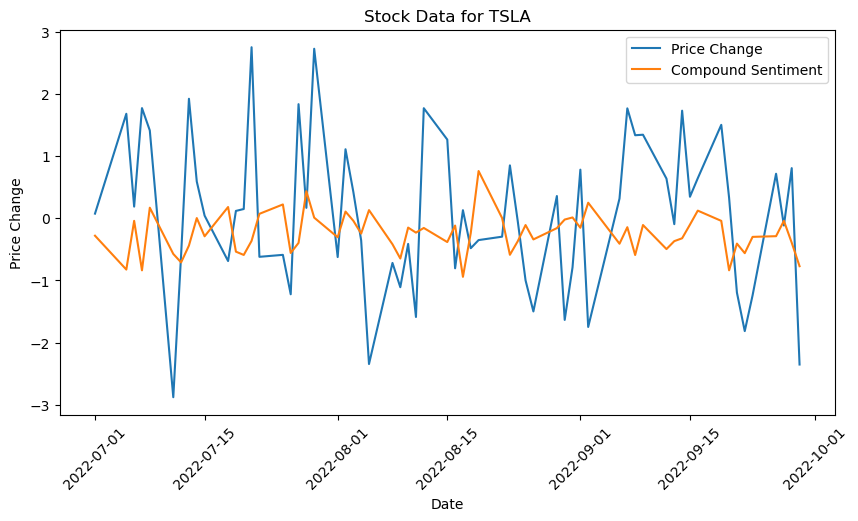

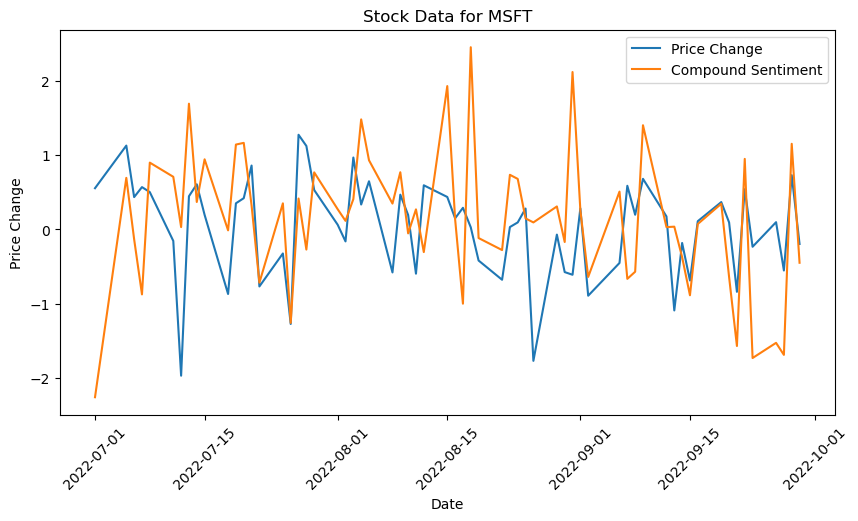

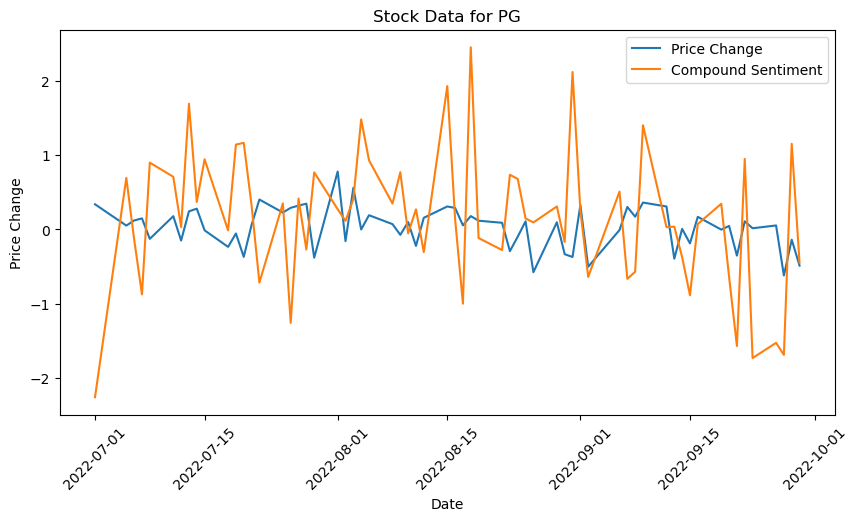

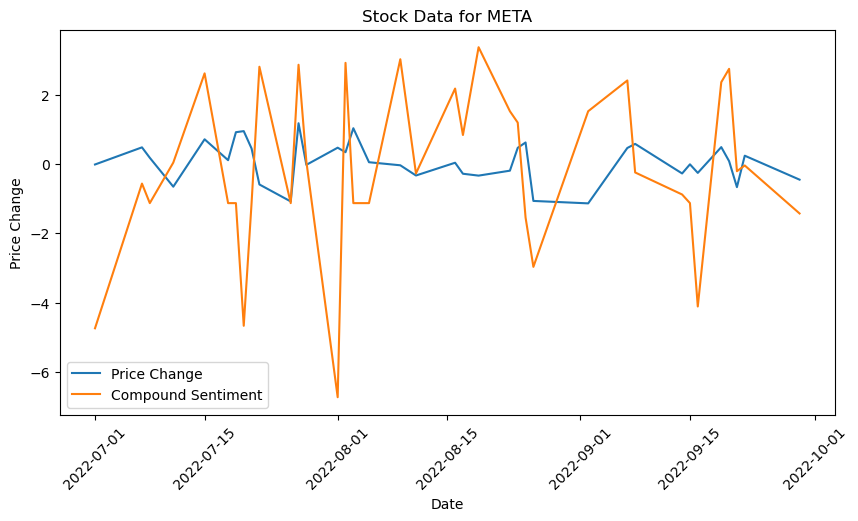

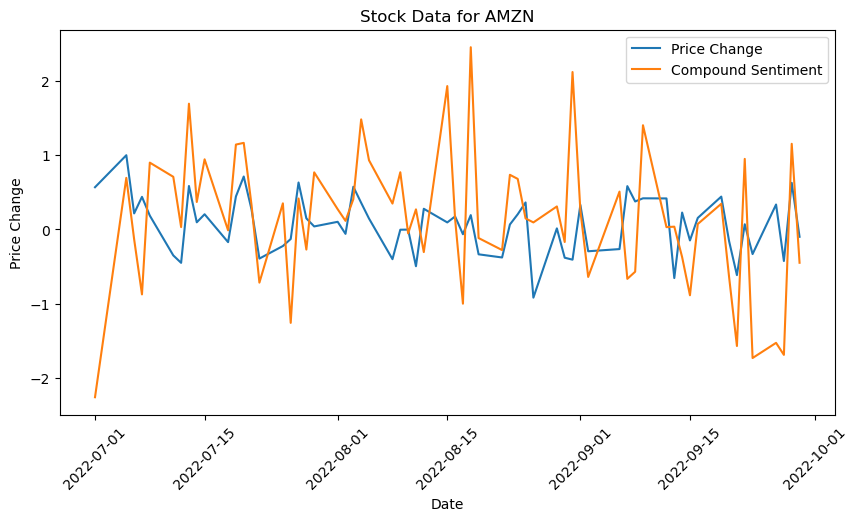

In [238]:
# Define the specific date range
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
start_date = '2022-07-01'
end_date = '2022-09-30'

merged_df = merged_df[(merged_df['Date'] >= start_date) & (merged_df['Date'] <= end_date)]

for stock_name in stock_names_of_interest:
    # Filter the DataFrame for the current stock
    stock_df = merged_df[merged_df['Stock Name'] == stock_name]
    
    # Plot the stock data
    plt.figure(figsize=(10, 5))
    plt.plot(stock_df['Date'], stock_df[['Price Change', 'Mean Compound']], label=stock_name)
    plt.title(f'Stock Data for {stock_name}')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Price Change')
    plt.legend(['Price Change', 'Compound Sentiment'])
    plt.show()

In [239]:
df_tsla = merged_df[merged_df['Stock Name'] == 'TSLA']
df_msft = merged_df[merged_df['Stock Name'] == 'MSFT']
df_pg = merged_df[merged_df['Stock Name'] == 'PG']
df_meta = merged_df[merged_df['Stock Name'] == 'META']
df_amzn = merged_df[merged_df['Stock Name'] == 'AMZN']

### Predict TSLA Sentiment

In [240]:
# Prepare data for Prophet
tsla_sentiment_prophet_df = df_tsla.rename(columns={'Date': 'ds', 'Mean Compound': 'y'})

# Convert 'ds' to datetime
tsla_sentiment_prophet_df['ds'] = pd.to_datetime(tsla_sentiment_prophet_df['ds'])

# Check the DataFrame
tsla_sentiment_prophet_df

,ds,Stock Name,Price Change,y
189,2022-07-01,TSLA,0.074863,-0.280177
190,2022-07-05,TSLA,1.680833,-0.824680
191,2022-07-06,TSLA,0.187898,-0.041392
192,2022-07-07,TSLA,1.772026,-0.836963
193,2022-07-08,TSLA,1.412717,0.170290
...,...,...,...,...
247,2022-09-23,TSLA,-1.239512,-0.298939
248,2022-09-26,TSLA,0.716490,-0.287775
249,2022-09-27,TSLA,-0.115712,-0.041141
250,2022-09-28,TSLA,0.806588,-0.392712


In [246]:
model = Prophet()

# Fit the model on the historical sentiment data
model.fit(tsla_sentiment_prophet_df)

# Create a future dataframe for the next 30 days
future = model.make_future_dataframe(periods=90)

# Forecast future sentiment values
forecast_sentiment = model.predict(future)

# Display the forecasted sentiment values (yhat is the predicted value)
print(forecast_sentiment[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

19:47:40 - cmdstanpy - INFO - Chain [1] start processing
19:47:40 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat  yhat_lower  yhat_upper
0   2022-07-01  0.000765   -0.382922    0.367267
1   2022-07-05 -0.429238   -0.806028   -0.046272
2   2022-07-06 -0.327043   -0.720704    0.028077
3   2022-07-07 -0.291789   -0.663000    0.074127
4   2022-07-08  0.001271   -0.389297    0.382392
..         ...       ...         ...         ...
148 2022-12-24  0.152305   -0.208172    0.540577
149 2022-12-25  0.152377   -0.238440    0.568015
150 2022-12-26 -0.194950   -0.572797    0.165298
151 2022-12-27 -0.416583   -0.751218   -0.036192
152 2022-12-28 -0.314388   -0.679586    0.027021

[153 rows x 4 columns]


In [247]:
# Prepare forecasted sentiment data for future stock price prediction
forecasted_sentiment_df = forecast_sentiment[['ds', 'yhat']].rename(columns={'yhat': 'Sentiment'})

forecasted_sentiment_df

,ds,Sentiment
0,2022-07-01,0.000765
1,2022-07-05,-0.429238
2,2022-07-06,-0.327043
3,2022-07-07,-0.291789
4,2022-07-08,0.001271
...,...,...
148,2022-12-24,0.152305
149,2022-12-25,0.152377
150,2022-12-26,-0.194950
151,2022-12-27,-0.416583


### Predict TSLA Price Change

In [248]:
# Prepare data for Prophet
df_tsla = df_tsla.rename(columns={'Date': 'ds', 'Price Change': 'y'})

# Convert 'ds' to datetime
df_tsla['ds'] = pd.to_datetime(df_tsla['ds'])


In [251]:
# Merge stock price data with sentiment forecast
merged_data = pd.merge(df_tsla, forecasted_sentiment_df, on='ds', how='left')

# Check the DataFrame
merged_data


,ds,Stock Name,y,Mean Compound,Sentiment
0,2022-07-01,TSLA,0.074863,-0.280177,0.000765
1,2022-07-05,TSLA,1.680833,-0.824680,-0.429238
2,2022-07-06,TSLA,0.187898,-0.041392,-0.327043
3,2022-07-07,TSLA,1.772026,-0.836963,-0.291789
4,2022-07-08,TSLA,1.412717,0.170290,0.001271
...,...,...,...,...,...
58,2022-09-23,TSLA,-1.239512,-0.298939,0.006839
59,2022-09-26,TSLA,0.716490,-0.287775,-0.201531
60,2022-09-27,TSLA,-0.115712,-0.041141,-0.423163
61,2022-09-28,TSLA,0.806588,-0.392712,-0.320968


In [252]:
# Initialize the Prophet model
model = Prophet()

# Add the sentiment as an additional regressor
model.add_regressor('Sentiment')

# Fit the model with both stock price and sentiment data
model.fit(merged_data)

19:50:27 - cmdstanpy - INFO - Chain [1] start processing
19:50:27 - cmdstanpy - INFO - Chain [1] done processing


In [257]:
# Create a dataframe for future stock price predictions (e.g., 30 days into the future)
future = model.make_future_dataframe(periods=90)

# Merge with forecasted sentiment for future dates
future = pd.merge(future, forecasted_sentiment_df, on='ds', how='left')

# Forecast future stock prices using the model
forecast = model.predict(future)

# Display the forecasted stock price changes
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])



            ds      yhat  yhat_lower  yhat_upper
0   2022-07-01  0.253358   -1.307363    1.734118
1   2022-07-05  0.147560   -1.423442    1.672970
2   2022-07-06  0.737726   -0.629790    2.275754
3   2022-07-07  0.248832   -1.295838    1.863315
4   2022-07-08  0.213909   -1.334501    1.733103
..         ...       ...         ...         ...
148 2022-12-24 -1.344644   -2.855283    0.209112
149 2022-12-25 -1.350279   -2.868071    0.215281
150 2022-12-26 -0.857835   -2.438033    0.688176
151 2022-12-27 -0.838666   -2.383980    0.713548
152 2022-12-28 -0.248500   -1.774475    1.234967

[153 rows x 4 columns]


c:\Users\mdmoo\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\mdmoo\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


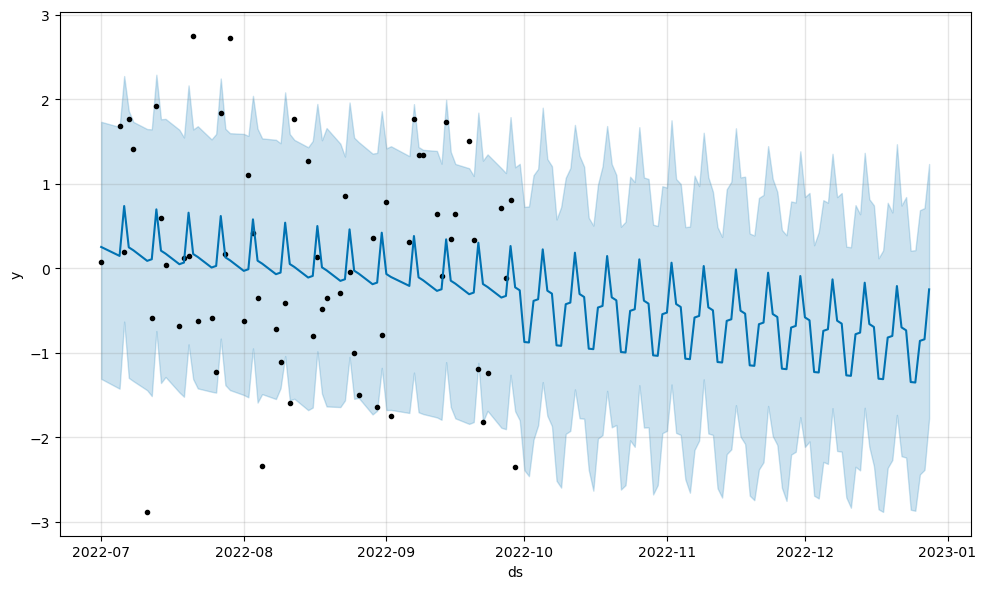

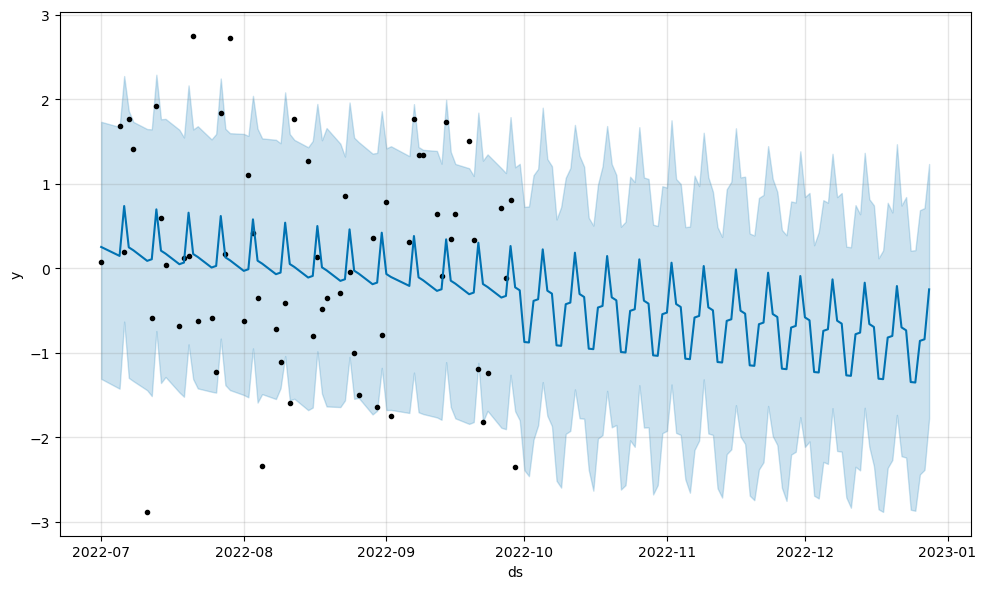

In [258]:
model.plot(forecast)

In [170]:
# merged_df.to_csv('merged_data.csv', index=True)